In [1]:
from pynse import *
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
#import mplfinance as mpf
import time, asyncio
import matplotlib.dates as mdates
import mplfinance as mpf
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime
import os
import glob
import pandas as pd
import mplfinance as mpf
from matplotlib.dates import MonthLocator, DateFormatter
import scipy.stats as stats
from tvDatafeed import TvDatafeed,Interval
tv=TvDatafeed()
import concurrent.futures

nse=Nse()
#nse.bhavcopy(series="all")
#bhavcopy_full=nse.bhavcopy(series="all")

you are using nologin method, data you access may be limited


CHECK IF YOU HAVE UPDATED BOTH THE SOURCE FOLDERS !! THATS IMP, Update the 'Price, PE, EBITDA , EV & Mcap' and 'MF folder in daily updates folder

In [2]:


folder_path = "C:/Users/99111/OneDrive/Desktop/Full data set/Price, PE, EBITDA , EV & Mcap/*.csv"

files = glob.glob(folder_path)

df_list = []

for file in files:
    df = pd.read_csv(file)
    df_list.append(df)

PEMCAP = pd.concat(df_list)
#PEMCAP = PEMCAP.rename(columns={'NDP_Date': 'Date'})
PEMCAP['NDP_Date'] = pd.to_datetime(PEMCAP['NDP_Date'])
Sectors = PEMCAP['CD_Sector'].unique().tolist()
Industrys = PEMCAP['CD_Industry'].unique().tolist()
PEMCAP = PEMCAP.loc[:, ['CD_NSE Symbol', 'CD_Sector' , 'CD_Industry', 'NDP_Date', 'NDP_Mcap','NDP_Consolidated PE', 'NDP_Consolidated EV EBIDTA']].copy()
#PEMCAP['uniquecode'] = PEMCAP['CD_NSE Symbol'] + PEMCAP['NDP_Date'].astype(str)


folder_path = "C:/Users/99111/OneDrive/Desktop/daily updates/Mutualfunds data/data/*.csv"

#C:/Users/99111/OneDrive/Desktop/daily updates/Mutualfunds data/data

files = glob.glob(folder_path)

df_list = []

for file in files:
    df = pd.read_csv(file)
    df_list.append(df)

combined_df = pd.concat(df_list)

combined_df = combined_df.drop(columns=['Sr.No', 'Accord Code'])

df=combined_df

df['MF_Month End'] = pd.to_datetime(df['MF_Month End'], format='%Y%m')
df['MF_Month End'] = df['MF_Month End'] + pd.offsets.MonthEnd(0)
symbols = df['CD_NSE Symbol'].unique().tolist()

SAVING CSV FILES FOR PROCESSED DATA WHICH ARE THEN USED TO PRODUCE CHARTS IN THE BELOW CODE

In [3]:
data = pd.DataFrame()

for symbol in symbols:
    try:

        df1 = df[df["CD_NSE Symbol"] == symbol].copy()

        result = df1.groupby('MF_Month End')[['MF_No of Shares', 'MF_Market Value']].sum()
        result_df = pd.DataFrame(result)
        result_df['SYMBOL'] = symbol

        result_df = result_df.reset_index(drop=False)
        result_df = result_df.sort_values(by='MF_Month End', ascending=True)
        latest_date = result_df['MF_Month End'].max()

        result_df["Averageprice"] = (result_df["MF_Market Value"]*10000000) / result_df["MF_No of Shares"]
        result_df["Holdingchange"] = result_df["MF_No of Shares"] - result_df["MF_No of Shares"].shift(1)
        result_df["Holdingchangesummation"] = result_df["Holdingchange"].rolling(12).sum()
        result_df["MoneyIn/Out"] = (result_df["Averageprice"] * result_df["Holdingchange"]) / 10000000
        result_df['uniquecode'] = result_df['SYMBOL'] + result_df['MF_Month End'].astype(str)

        result_df['MoneyIn'] = np.where(result_df['MoneyIn/Out'] > 0, result_df['MoneyIn/Out'], 0) 
        result_df['weightedPrice'] = result_df['MoneyIn'] * result_df['Averageprice']

        result_df['6MonthsWP'] = result_df['weightedPrice'].rolling(6).sum() / result_df['MoneyIn'].rolling(6).sum()
        result_df['1yrWP'] = result_df['weightedPrice'].rolling(12).sum() / result_df['MoneyIn'].rolling(12).sum()
        result_df['3yrWP'] = result_df['weightedPrice'].rolling(36).sum() / result_df['MoneyIn'].rolling(36).sum()

        result_df['6MonthsWP'] = result_df['6MonthsWP'].fillna(method='ffill')
        result_df['1yrWP'] = result_df['1yrWP'].fillna(method='ffill')
        result_df['3yrWP'] = result_df['3yrWP'].fillna(method='ffill')

        #############################

        PEMCAP1 = PEMCAP[PEMCAP["CD_NSE Symbol"] == symbol].copy()
        PEMCAP1 = PEMCAP1.sort_values(by='NDP_Date', ascending=True)
        date_range = pd.date_range(start=PEMCAP1['NDP_Date'].min(), end=PEMCAP1['NDP_Date'].max(), freq='D')
        all_dates_df = pd.DataFrame({'NDP_Date': date_range})

        final_df = pd.merge(all_dates_df, PEMCAP1, on='NDP_Date', how='left')

        final_df['CD_NSE Symbol'] = final_df['CD_NSE Symbol'].fillna(method='ffill')
        final_df['CD_Sector'] = final_df['CD_Sector'].fillna(method='ffill')
        final_df['CD_Industry'] = final_df['CD_Industry'].fillna(method='ffill')
        final_df['NDP_Mcap'] = final_df['NDP_Mcap'].fillna(method='ffill')
        final_df['NDP_Consolidated PE'] = final_df['NDP_Consolidated PE'].fillna(method='ffill')
        final_df['NDP_Consolidated EV EBIDTA'] = final_df['NDP_Consolidated EV EBIDTA'].fillna(method='ffill')
        final_df['uniquecode'] = final_df['CD_NSE Symbol'] + final_df['NDP_Date'].astype(str)
        final_df = final_df.drop_duplicates(subset='uniquecode')

        merged_df = pd.merge(result_df, final_df, on='uniquecode', how='left')

        merged_df['CD_NSE Symbol'] = merged_df['CD_NSE Symbol'].fillna(method='ffill')
        merged_df['CD_Sector'] = merged_df['CD_Sector'].fillna(method='ffill')
        merged_df['CD_Industry'] = merged_df['CD_Industry'].fillna(method='ffill')
        merged_df['NDP_Mcap'] = merged_df['NDP_Mcap'].fillna(method='ffill')   
        merged_df['NDP_Consolidated PE'] = merged_df['NDP_Consolidated PE'].fillna(method='ffill')
        merged_df['NDP_Consolidated EV EBIDTA'] = merged_df['NDP_Consolidated EV EBIDTA'].fillna(method='ffill')    

        merged_df['weightedMCAP'] = merged_df['MoneyIn'] * merged_df['NDP_Mcap']
        merged_df['6MonthsWMCAP'] = merged_df['weightedMCAP'].rolling(6).sum() / merged_df['MoneyIn'].rolling(6).sum()
        merged_df['1yrWMCAP'] = merged_df['weightedMCAP'].rolling(12).sum() / merged_df['MoneyIn'].rolling(12).sum()
        merged_df['3yrWMCAP'] = merged_df['weightedMCAP'].rolling(36).sum() / merged_df['MoneyIn'].rolling(36).sum()

        merged_df['6MonthsWMCAP'] = merged_df['6MonthsWMCAP'].fillna(method='ffill')
        merged_df['1yrWMCAP'] = merged_df['1yrWMCAP'].fillna(method='ffill')
        merged_df['3yrWMCAP'] = merged_df['3yrWMCAP'].fillna(method='ffill')

        ########################################################################
        data = pd.concat([data, merged_df], axis=0, ignore_index=True)

    except Exception as e:
                print(f"Error while processing outer forloop {symbol}: {e}")
                continue
    
output_directory = r'C:\Users\99111\OneDrive\Desktop\daily updates\Mutualfunds data\Processed Data'
output_filename = f'ProcessedData.csv'
output_path = os.path.join(output_directory, output_filename)
data.to_csv(output_path, index=False)

Error while processing outer forloop AUTOPALIND: Neither `start` nor `end` can be NaT
Error while processing outer forloop nan: Neither `start` nor `end` can be NaT
Error while processing outer forloop GEORGFISCH: Neither `start` nor `end` can be NaT
Error while processing outer forloop SQRDSFWARE: Neither `start` nor `end` can be NaT
Error while processing outer forloop ELBEE: Neither `start` nor `end` can be NaT
Error while processing outer forloop HAWKINCOOK: Neither `start` nor `end` can be NaT
Error while processing outer forloop ITIL: Neither `start` nor `end` can be NaT
Error while processing outer forloop FLATPROD: Neither `start` nor `end` can be NaT
Error while processing outer forloop KGKHOSLA: Neither `start` nor `end` can be NaT
Error while processing outer forloop KOTHARINDL: Neither `start` nor `end` can be NaT
Error while processing outer forloop MAHENDSUIT: Neither `start` nor `end` can be NaT
Error while processing outer forloop MODERNDENM: Neither `start` nor `end` c

CREATING A CHART for MUTUAL FUNDS MONTHLY NET INVESTMENTS, saved here at 'C:\Users\99111\OneDrive\Desktop\daily updates\Mutualfunds data' 

CREATING A LIST OF FILTERED SYMBOLS BASED ON @ FILTERS

BoughtFlag1 -  (Trending Buy)                                   BoughtFlag1 -   (down & out buy)                        
                MoneyIn/Out > 0    (in the past 6 months)                       MoneyIn/Out > 0      
                6MonthsWMCAP > 1yrWMCAP                                         6MonthsWMCAP > 1yrWMCAP 
                6MonthsWMCAP > 3yrWMCAP                                         6MonthsWMCAP > 3yrWMCAP
                Averageprice > 3yrWMCAP                                         Averageprice < 3yrWMCAP
                Averageprice < 6MonthsWMCAP


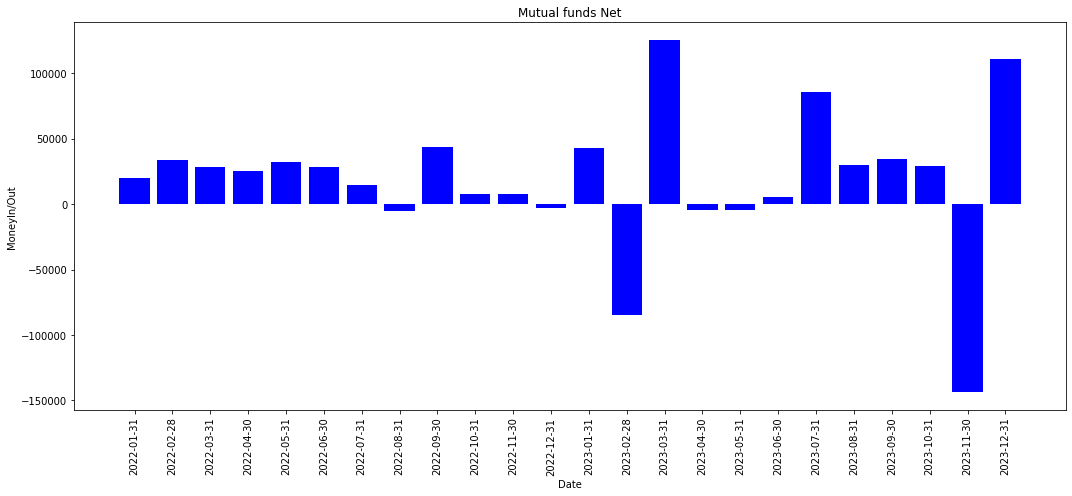

In [4]:
file_path = r'C:\Users\99111\OneDrive\Desktop\daily updates\Mutualfunds data\Processed Data\ProcessedData.csv'

df = pd.read_csv(file_path)

dates = df['MF_Month End'].unique().tolist()
df = df.sort_values(by='MF_Month End', ascending=True)

Pastmonths = 24
df1 = df.groupby('MF_Month End')[['MoneyIn/Out']].sum()
df1 = df1.reset_index(drop=False)

plt.figure(figsize=(15, 7))  # Adjust the dimensions as needed
# Create a solid bar chart
plt.bar(df1.tail(Pastmonths)['MF_Month End'], df1.tail(Pastmonths)['MoneyIn/Out'], color='blue')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('MoneyIn/Out')
plt.title('Mutual funds Net')

# Rotate the x-axis labels for better visibility (optional)
plt.xticks(rotation=90)

# Show the chart

plt.tight_layout()  # Helps with label visibility
plt.savefig(r'C:\Users\99111\OneDrive\Desktop\daily updates\Mutualfunds data\MF_Net.jpg')

#####################################################################################FILTER EXCEL

file_path = r'C:\Users\99111\OneDrive\Desktop\daily updates\Mutualfunds data\Processed Data\ProcessedData.csv'
df = pd.read_csv(file_path)

df = df.sort_values(by='MF_Month End', ascending=True)
dates = df['MF_Month End'].unique().tolist()

# Filter the DataFrame based on the list of dates
filtered_df = df[df['MF_Month End'].isin(dates[-6:])]
filtered_df = filtered_df.sort_values(by='MoneyIn/Out', ascending=False)

a = filtered_df['MoneyIn/Out'] > 0
b = filtered_df['6MonthsWMCAP'] > filtered_df['1yrWMCAP']  
c = filtered_df['6MonthsWMCAP'] > filtered_df['3yrWMCAP'] 

d = filtered_df['Averageprice'] > filtered_df['3yrWMCAP'] 
e = filtered_df['Averageprice'] < filtered_df['6MonthsWMCAP'] 

f = filtered_df['Averageprice'] < filtered_df['3yrWMCAP']

filtered_df['BoughtFlag1'] = np.where(np.logical_and.reduce((a, b, c, d,e)),1,0)
filtered_df['BoughtFlag2'] = np.where(np.logical_and.reduce((a, b, c,f)),1,0)

#df['Bigbuy'] = np.where((df['BoughtFlag1'] == 1) | (df['BoughtFlag2'] == 1), 1, 0)
#df = df.sort_values(by='MoneyIn/Out', ascending=False)
filtered_df = filtered_df[(filtered_df['BoughtFlag1'] == 1) | (filtered_df['BoughtFlag2'] == 1)]


output_directory = r'C:\Users\99111\OneDrive\Desktop\daily updates\Mutualfunds data'
output_filename = 'MF Filter.csv'
output_path = os.path.join(output_directory, output_filename)
filtered_df.to_csv(output_path, index=False)



LOADING DATA FOR PRODUCING CHARTS

In [5]:
file_path = r'C:\Users\99111\OneDrive\Desktop\daily updates\Mutualfunds data\Processed Data\ProcessedData.csv'
df = pd.read_csv(file_path)


file_path = r'C:\Users\99111\OneDrive\Desktop\daily updates\Mutualfunds data\MF Filter.csv'
symbols = pd.read_csv(file_path)
symbols = symbols['SYMBOL'].unique().tolist()

for symbol in symbols:
    try:

        dff = df[df["SYMBOL"] == symbol].copy()

        
        dateforWP = pd.to_datetime('2018-1-1')
        dateforHolding = pd.to_datetime('2022-1-1')

        df['MF_Month End'] = pd.to_datetime(df['MF_Month End'])
        df1 = dff[dff['MF_Month End'] >= dateforHolding]
        df2 = dff[dff['MF_Month End'] >= dateforWP]

        latest_date = df1['MF_Month End'].max()

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(26, 13), sharex=True)

        # Plot data on the first axis (ax1) with separate y-axes
        ax1.plot(df1['MF_Month End'],df1['Holdingchangesummation'], label='Holdingchangesummation', color='blue')
        ax1.axhline(0, color='blue')
        #ax1.set_ylabel('Values for Column 1')
        ax1.legend()

        ax1_2 = ax1.twinx()
        ax1_2.plot(df1['MF_Month End'],df1['MoneyIn/Out'], label='MoneyIn/Out', color='green')
        ax1_2.axhline(0, color='green')
        #ax1_2.set_ylabel('Values for Column 2')
        ax1_2.legend()

        ax1.xaxis.set_major_locator(MonthLocator())
        ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

        # Plot data on the second axis (ax2) with separate y-axes
        ax2.plot(df1['MF_Month End'],df1['NDP_Mcap'], label='NDP_Mcap', color='black')
        ax2.plot(df1['MF_Month End'],df1['6MonthsWMCAP'], label='6MonthsWMCAP', color='green')
        ax2.plot(df1['MF_Month End'],df1['1yrWMCAP'], label='1yrWMCAP', color='blue')
        ax2.plot(df1['MF_Month End'],df1['3yrWMCAP'], label='3yrWMCAP', color='red')

        #ax2.set_ylabel('Values for Column 3')
        ax2.legend()

        ax2_2 = ax2.twinx()
        ax2_2.plot(df1['MF_Month End'],df1['NDP_Consolidated EV EBIDTA'], label='NDP_Consolidated EV EBIDTA', color='green', linestyle='--')
        #ax1_2.set_ylabel('Values for Column 2')
        ax2_2.legend()

        # Add a common x-axis label and title
        fig.suptitle(symbol)
        plt.xlabel('Date')

        # Display the plot
        plt.tight_layout()

        save_dir = r'C:\Users\99111\OneDrive\Desktop\daily updates\Mutualfunds data\Charts'        
        chart_file = os.path.join(save_dir, f"{symbol}_Zoomin.jpg")
        plt.savefig(chart_file, dpi=100)

        # Close the figure to release resources
        plt.close(fig)

        ######################################################################

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(26, 13), sharex=True)

        # Plot data on the first axis (ax1) with separate y-axes
        ax1.plot(df2['MF_Month End'],df2['Holdingchangesummation'], label='Holdingchangesummation', color='blue')
        ax1.axhline(0, color='blue')
        #ax1.set_ylabel('Values for Column 1')
        ax1.legend()

        ax1_2 = ax1.twinx()
        ax1_2.plot(df2['MF_Month End'],df2['MoneyIn/Out'], label='MoneyIn/Out', color='green')
        ax1_2.axhline(0, color='green')
        #ax1_2.set_ylabel('Values for Column 2')
        ax1_2.legend()

        ax1.xaxis.set_major_locator(MonthLocator(interval=2))
        ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

        # Plot data on the second axis (ax2) with separate y-axes
        ax2.plot(df2['MF_Month End'],df2['NDP_Mcap'], label='NDP_Mcap', color='black')
        ax2.plot(df2['MF_Month End'],df2['6MonthsWMCAP'], label='6MonthsWMCAP', color='green')
        ax2.plot(df2['MF_Month End'],df2['1yrWMCAP'], label='1yrWMCAP', color='blue')
        ax2.plot(df2['MF_Month End'],df2['3yrWMCAP'], label='3yrWMCAP', color='red')

        #ax2.set_ylabel('Values for Column 3')
        ax2.legend()

        ax2_2 = ax2.twinx()
        ax2_2.plot(df2['MF_Month End'],df2['NDP_Consolidated EV EBIDTA'], label='NDP_Consolidated EV EBIDTA', color='green', linestyle='--' )
        #ax1_2.set_ylabel('Values for Column 2')
        ax2_2.legend()


        # Add a common x-axis label and title
        fig.suptitle(symbol)
        plt.xlabel('Date')

        # Display the plot
        plt.tight_layout()

        save_dir = r'C:\Users\99111\OneDrive\Desktop\daily updates\Mutualfunds data\Charts'        
        chart_file = os.path.join(save_dir, f"{symbol}__Zoomout.jpg")
        plt.savefig(chart_file, dpi=100)

        # Close the figure to release resources
        plt.close(fig)

    except Exception as e:
                print(f"Error while processing outer forloop {symbol}: {e}")
                continue

Error while processing outer forloop HDFCBANK: '>=' not supported between instances of 'str' and 'Timestamp'
